In [20]:
import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display

from my_models import VGG

In [12]:
in_channels = 3
out_channels = 10
device = "cuda:0"
net = VGG(in_channels = in_channels, 
            out_channels = out_channels,
            conv_blocks_out_size = [32,64,64,128,128], 
            conv_blocks_amounts = [1,1,2,2,2],
            linear_layers_out_size = [200,200,out_channels])
net.to(device)

train_loss = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

batch_size = 10000
epoch_num = 10

In [13]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
             xConv-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
             xConv-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,928
            Conv2d-6             [-1, 64, 8, 8]          36,928
             xConv-7             [-1, 64, 4, 4]               0
            Conv2d-8            [-1, 128, 4, 4]          73,856
            Conv2d-9            [-1, 128, 4, 4]         147,584
            xConv-10            [-1, 128, 2, 2]               0
           Conv2d-11            [-1, 128, 2, 2]         147,584
           Conv2d-12            [-1, 128, 2, 2]         147,584
            xConv-13            [-1, 128, 1, 1]               0
           Linear-14                  [

In [82]:
from fastai.vision.all import *

path = URLs.IMAGENETTE_160

In [75]:
def get_dls(path, size, batch_size, workers=None):
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    # Resize seems to give slightly better accuracy than RandomResizedCrop
    resize_ftm = Resize(size) # RandomResizedCrop(size, min_scale=0.35)
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label,
                       item_tfms=[resize_ftm])
    return dblock.dataloaders(source, path=source, bs=batch_size, num_workers=workers)

In [83]:
(untar_data(path)).ls()

(#2) [Path('/root/.fastai/data/imagenette2-160/train'),Path('/root/.fastai/data/imagenette2-160/val')]

In [76]:
dataloaders = get_dls(path, 160, 100)

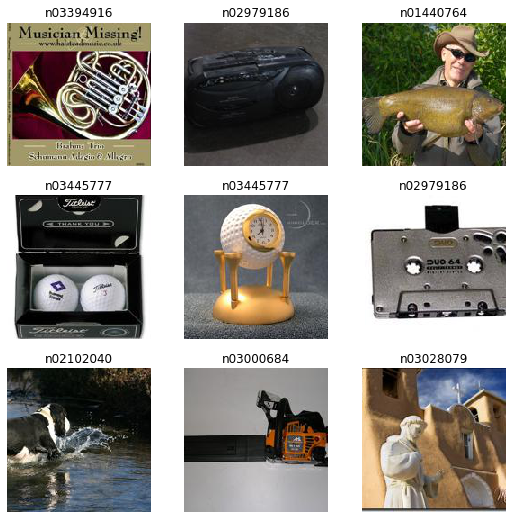

In [77]:
dataloaders.show_batch()

In [14]:
data_dir="./data/CIFAR"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
test_abs = int(len(trainset) * 0.8)
train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True)
valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=True)

testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False)

In [32]:
def accuracy_and_loss(dataloader, net, device, criterion, enable_loss=True):
    current_loss = 0.0
    steps = 0
    total = 0
    correct = 0
    
    for i, data in enumerate(dataloader, 0):
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if enable_loss:
                loss = criterion(outputs, labels)
                current_loss += loss.cpu().numpy()
            steps += 1
    if enable_loss: 
        current_loss /= steps
    accuracy = correct / total
    return accuracy, current_loss

In [29]:
def train(net, optimizer, criterion, epoch_num, trainloader, valloader, device):
    val_loss_history = np.array([], float)
    val_accuracy_history = np.array([], float)
    train_accuracy_history = np.array([], float)
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # Train accuracy
        current_train_accuracy, _ = accuracy_and_loss(trainloader, net, device, criterion, False)     
        train_accuracy_history = np.append(train_accuracy_history, current_train_accuracy)

        # Validation accuracy and loss
        current_val_accuracy, current_val_loss = accuracy_and_loss(valloader, net, device, criterion)     
        val_loss_history = np.append(val_loss_history, current_val_loss)
        val_accuracy_history = np.append(val_accuracy_history, current_val_accuracy)
        
        # visulization:
        display.clear_output(wait=True)
        # train accuracy:
        plt.figure(figsize=(8, 6))
        
        plt.title("Train accuracy")
        plt.xlabel("epoch number")
        plt.ylabel("accuracy")
        plt.plot(train_accuracy_history, 'b')
        plt.show()       
        
        # val loss
        plt.figure(figsize=(8, 6))
        
        plt.title("Validation loss")
        plt.xlabel("epoch number")
        plt.ylabel("loss")
        plt.plot(val_loss_history, 'b')
        plt.show()       
        
        # val accuracy
        plt.figure(figsize=(8, 6))
        
        plt.title("Validation accuracy")
        plt.xlabel("epoch number")
        plt.ylabel("accuracy")
        plt.plot(val_accuracy_history, 'b')
        plt.show()
        print('Current train accuracy: %f' % current_train_accuracy)
        print('Current validation loss: %f' % current_val_loss)
        print('Current validation accuracy: %f' % current_val_accuracy)
    return net

In [30]:
def test_accuracy(net, device, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

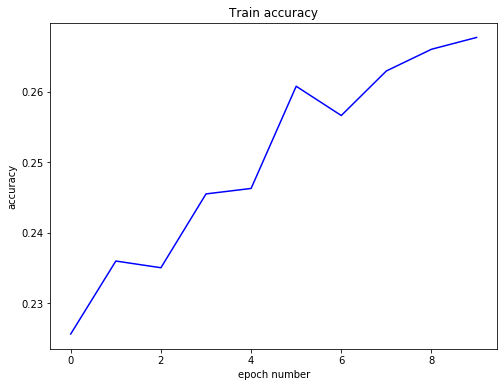

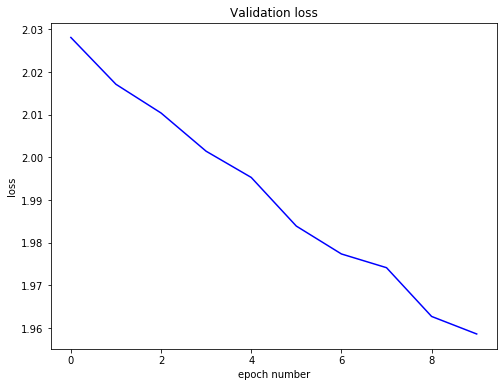

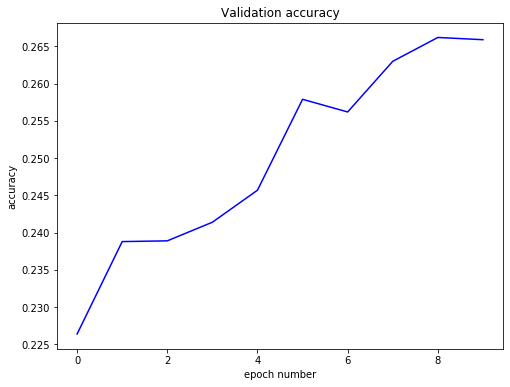

Current train accuracy: 0.267725
Current validation loss: 1.958631
Current validation accuracy: 0.265900
Test accuracy:  0.2686


In [33]:
net = train(net, optimizer, train_loss, epoch_num, trainloader, valloader, device)
print("Test accuracy: ", test_accuracy(net, device, testloader))